In [2]:
import os                              
import numpy as np
from numpy import number                    
import pandas as pd                     
import matplotlib.pyplot as plt  
import math
from typing import List
from azure.quantum.optimization import Problem, ProblemType, Term
from azure.quantum.optimization import ParallelTempering
from azure.quantum.optimization import Term, SlcTerm

In [3]:
stocks = [stock.split('.')[0] for stock in sorted(os.listdir("Datasets/Bombay Stock Exchange Top 50 (last 20 years data)"))]
stocks = stocks[1:]

dates = pd.date_range('2020-06-27', '2022-06-27') 
data = pd.DataFrame({'Time': dates})
for stock in stocks:
    prices = pd.read_csv("Datasets/Bombay Stock Exchange Top 50 (last 20 years data)/"+stock+".csv", usecols=['Date', 'WAP'])
    #print(prices)
    prices['Date'] = pd.to_datetime(prices['Date'], dayfirst = True)  
    #print(prices)
    prices.rename(                                                            
        columns={"Date": "Time", "WAP": stock},
        inplace=True
    )
    data = pd.merge(data,prices)


In [4]:
r = data[(data['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
mu = r.mean().to_numpy()
sigma = r.cov().to_numpy()
n=len(stocks)

In [5]:
# Getting selected stocks its prices from the output of our model
selected_stocks = ['ADANIENT', 'ADANIGREEN', 'ADANIPOWER', 'ADANITRANS', 'ATGL', 'HCLTECH', 'ICICIBANK', 'INFY', 'ITC', 'JSWSTEEL', 'POWERGRID', 'TATAMOTORS', 'TATASTEEL', 'TITAN', 'WIPRO']

index_prices_selected = [0, 1, 3, 4, 6, 17, 23, 24, 26, 27, 36, 42, 43, 46, 48]

result = {'0': 1, '1': 1, '2': 0, '3': 1, '4': 1, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 1, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 1, '25': 0, '26': 0, '27': 1, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 1, '40': 1, '41': 1, '42': 1, '43': 0, '44': 0, '45': 0, '46': 1, '47': 0, '48': 0}

In [6]:
portfolio = pd.DataFrame(data['Time'])
for i in range(len(selected_stocks)):
       portfolio = portfolio.join(data[data.columns[1+index_prices_selected[i]]])
       
pr = portfolio[(portfolio['Time'] >= '2020-06-27')] \
    .drop(['Time'], axis=1) \
    .pct_change(fill_method='ffill')
pr.head()

pmu = pr.mean().to_numpy()
psigma = pr.cov().to_numpy()

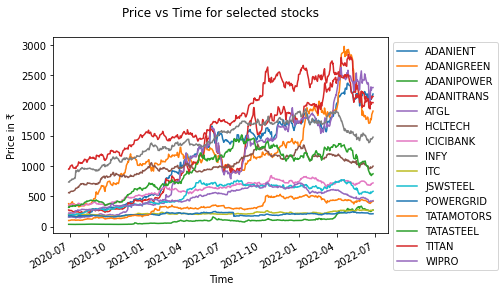

In [8]:
portfolio.plot(x ='Time', y = portfolio.columns[1:], kind = 'line')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Price in \u20B9')
plt.title('Price vs Time for selected stocks\n')
plt.show()

In [9]:
def find_expected_daily_return_sp(weights,portfolio_mu,n):
    '''
    Calculates the expected return for the optimised portfolio
    
    Parameters
    ----------
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    expected_dialy_roi: float
        Expected daily return on inverstment of the optimised portfolio
    
    '''
    expected_daily_roi=0
    for i in range(0,n):
        t = weights[i] * portfolio_mu[i]
        expected_daily_roi+=t
    return expected_daily_roi

In [10]:
from statistics import variance


def find_risk_sp(weights,portfolio_var,n):

    '''Calculates the risk for the optimised portfolio
    
    Parameters
    ----------
    B: float
        budget to be equally invested
    weights: np.array
        weights of the selected stocks

    Returns
    -------
    risk_perc: float
        percetnage risk value of the optimised portfolio with given budget
    '''
    
    var=0
    for i in range(0,n):
        for j in range(0,n):
            t = weights[i]  * weights[j] * portfolio_var[i][j]
            var+=t
    risk = var**0.5
    risk_perc = risk * 100
    return risk_perc

In [11]:
def randomly_weighted_portfolios_with_selected_stocks(nof_portfolio, portfolio_return, portfolio_sigma):
    all_w_list = []
    all_b_list = []
    weight = np.random.random(len(selected_stocks))
    weight /= np.sum(weight)
    all_w_list.append(weight)
    random_portfolios = np.zeros((2,nof_portfolio))
    for i in range(nof_portfolio):
        weight = np.random.random(len(selected_stocks))
        weight /= np.sum(weight)
        all_w_list.append(weight)
        random_portfolios[0,i] = find_expected_daily_return_sp(weight, portfolio_return,len(selected_stocks))*30*100
        random_portfolios[1,i] = find_risk_sp(weight, portfolio_sigma,len(selected_stocks))
    return random_portfolios

In [51]:
def visualize_efficient_frontier_for_selected_stocks():
    simulated_portfolios = randomly_weighted_portfolios_with_selected_stocks(25000,pmu,psigma)
    plt.figure(figsize=(10, 7))
    
    plt.scatter(simulated_portfolios[1,:],simulated_portfolios[0,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.ylabel('Expected Monthly retrun on investment')
    plt.xlabel('Risk Percentage')
    plt.plot(1.206242537089891, 6.090924279657758, marker="o" , markeredgecolor="red", markerfacecolor="green")
    plt.show()

In [52]:
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns


all_prices=  data.drop(['Time'], axis=1)
sample_cov = risk_models.sample_cov(all_prices, frequency=252)
muc = expected_returns.mean_historical_return(all_prices)


w_classical = [0.0161,0.24485, 0.10312 , 0.23497, 0.01057, 0.20492, 0.13906, 0.04642]
w_classical_all = [0,0.0161,0,0.24485,0.10312,0,0.23497,0,0,0,0,0.01057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.20492,0,0,0,0.13906,0,0,0,0,0,0,0,0,0,0,0.04642,0,0,0,0,0,0,0]
return_based_on_classical_w = find_expected_daily_return_sp(w_classical, muc, 8)*22

risk_based_on_classical_w  = find_risk_sp(w_classical_all, (sample_cov.reset_index(drop = True)).to_numpy(), 49)
print(return_based_on_classical_w,risk_based_on_classical_w)


28.691789345712255 29.73474442716532


In [53]:
import functions
quantum_risk = functions.find_risk(selected_stocks,n,result,sigma)
edroi = functions.find_expected_daily_return(mu,selected_stocks,index_prices_selected)
quantum_return = edroi * 22 *100
print(quantum_risk,quantum_return)

1.206242537089891 6.090924279657758


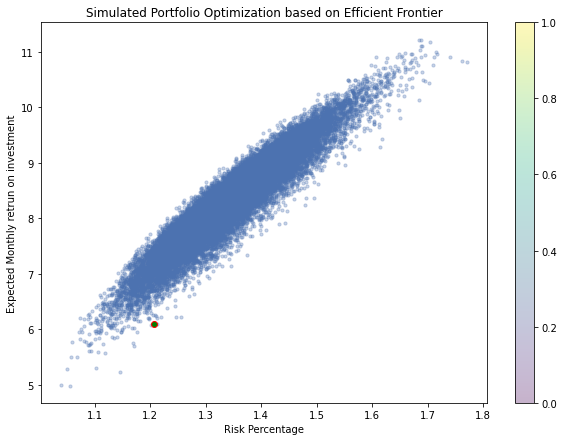

In [54]:
visualize_efficient_frontier_for_selected_stocks()